# Week 9

This notebook will contain code and results for the work of week 9

## Ice Thickness data
Our first task is to open and deal with the sea ice thickness data which we have downloaded. Can we make it useful somehow?

In [1]:
import glob
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import xarray as xr

In [2]:
# Extracting the downloaded data from files
# import tarfile

# for fname in glob.glob('data/seaice thickness/*'):

#     if fname.endswith("tgz"):
#         tar = tarfile.open(fname, "r:gz")
#         tar.extractall('data/seaice thickness/')
#         tar.close()
#     elif fname.endswith("tar"):
#         tar = tarfile.open(fname, "r:")
#         tar.extractall('data/seaice thickness/')
#         tar.close()

In [3]:
# Loading the extracted data into dataframes
dfs = {}
for fname in glob.glob('data/seaice thickness/*.txt'):
    df = pd.read_csv(fname, sep='    ', names = ['lat','lon','Sea Ice Freeboard [m]', 'Sea Ice Thickness [m]'])
    df.name = fname.split('\\')[-1].split('_')[0]
    dfs[df.name] = df


In [4]:
# Saving to an xarray dataset
Y, X = [10*np.arange(435000,-395000,-2500),
			10*np.arange(-395000,395000,2500)]

newdata = xr.Dataset()
newdata['x'] = X
newdata['y'] = Y
for key in dfs:
    newdata[key] = (('x','y'), dfs.get(key)['Sea Ice Thickness [m]'].values.reshape(316,332))
    newdata[key] = newdata[key].where(newdata[key] != -999)
    newdata[key] = newdata[key].where(newdata[key] != 0.0)
newdata['mean_thickness'] = (('x','y'), np.nanmean([newdata.spring, newdata.fall, newdata.summer], axis = (0)))
newdata.to_netcdf('processed_data/seaice_thickness.nc')

In [5]:
newdata = xr.open_dataset('processed_data/seaice_thickness.nc')
newdata

<xarray.Dataset>
Dimensions:         (x: 316, y: 332)
Coordinates:
  * x               (x) int32 -3950000 -3925000 -3900000 ... 3900000 3925000
  * y               (y) int32 4350000 4325000 4300000 ... -3900000 -3925000
Data variables:
    fall            (x, y) float64 ...
    spring          (x, y) float64 ...
    summer          (x, y) float64 ...
    mean_thickness  (x, y) float64 ...

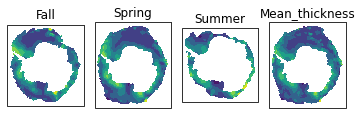

In [6]:
# Plotting to validate
fig, axes = plt.subplots(1,4,figsize=(5,20),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for i, key in enumerate(newdata):
    ax = axes[i]
    ax.contourf(newdata.x,newdata.y,newdata[key].transpose(), transform = ccrs.SouthPolarStereo())
    ax.set_title(key.capitalize())

# axes[3].contourf(newdata.x,newdata.y,newdata['mean_thickness'].transpose(), transform = ccrs.SouthPolarStereo())
# axes[3].set_title('Mean')
fig.tight_layout()
plt.show()

In [7]:
newdata

<xarray.Dataset>
Dimensions:         (x: 316, y: 332)
Coordinates:
  * x               (x) int32 -3950000 -3925000 -3900000 ... 3900000 3925000
  * y               (y) int32 4350000 4325000 4300000 ... -3900000 -3925000
Data variables:
    fall            (x, y) float64 ...
    spring          (x, y) float64 ...
    summer          (x, y) float64 ...
    mean_thickness  (x, y) float64 ...

# Trends and Variability of Antarctic Ice

In [8]:
sic = xr.open_dataset('processed_data/seaice.nc').sic
sic

<xarray.DataArray 'sic' (time: 494, y: 332, x: 316)>
[51826528 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2019-12-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000

In [11]:
area = xr.open_dataset('data/area_files/processed_nsidc.nc').area
sic_adjusted = sic * area / 250

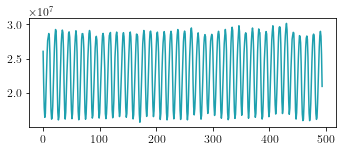

In [13]:
plt.style.use('stylesheets/timeseries.mplstyle')
fig, ax = plt.subplots()
ax.plot(sic_adjusted.time, sic_adjusted.sum(dim=('x','y')))